C:\Users\HG\AppData\Local\Temp\ipykernel_8640\2784957929.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_4[point] += 2.0 + np.random.normal(0,1,1)  # point anomaly - 두 번째 매개변수는 표준편차, 세 번째 매개변수는 생성할 난수의 개수


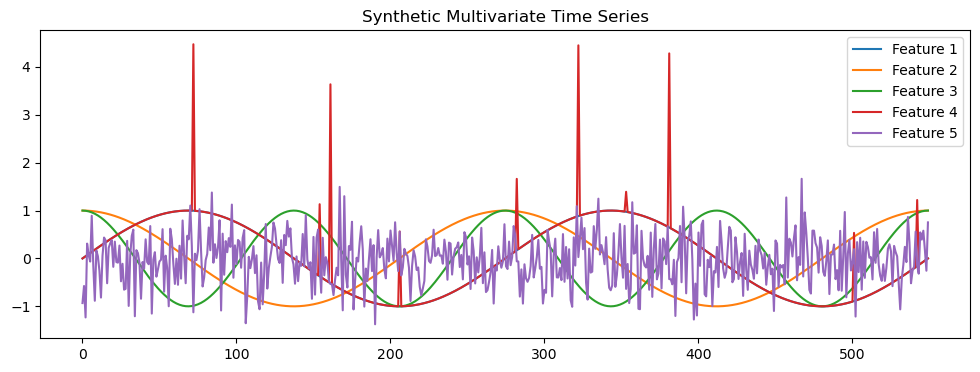

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

T = 550  # time steps
t = np.linspace(0, 4 * np.pi, T)

# Feature 구성
feature_1 = np.sin(t)
feature_2 = np.cos(t)
feature_3 = np.cos(2 * t)
feature_4 = np.sin(t).copy()
anomaly_point = [72, 154, 161, 206, 282, 322, 353, 381, 501, 542]
for point in anomaly_point:
    feature_4[point] += 2.0 + np.random.normal(0,1,1)  # point anomaly - 두 번째 매개변수는 표준편차, 세 번째 매개변수는 생성할 난수의 개수
feature_5 = np.random.normal(0, 0.5, T)

# Stack features: shape = (T, V)
X = np.stack([feature_1, feature_2, feature_3, feature_4, feature_5], axis=1)

# DataFrame으로 시각화
df = pd.DataFrame(X, columns=[f'Feature {i+1}' for i in range(5)])
df.plot(title="Synthetic Multivariate Time Series", figsize=(12, 4))
plt.show()

X_tensor shape: torch.Size([451, 100, 5])
X_embedded shape: torch.Size([451, 100, 16])


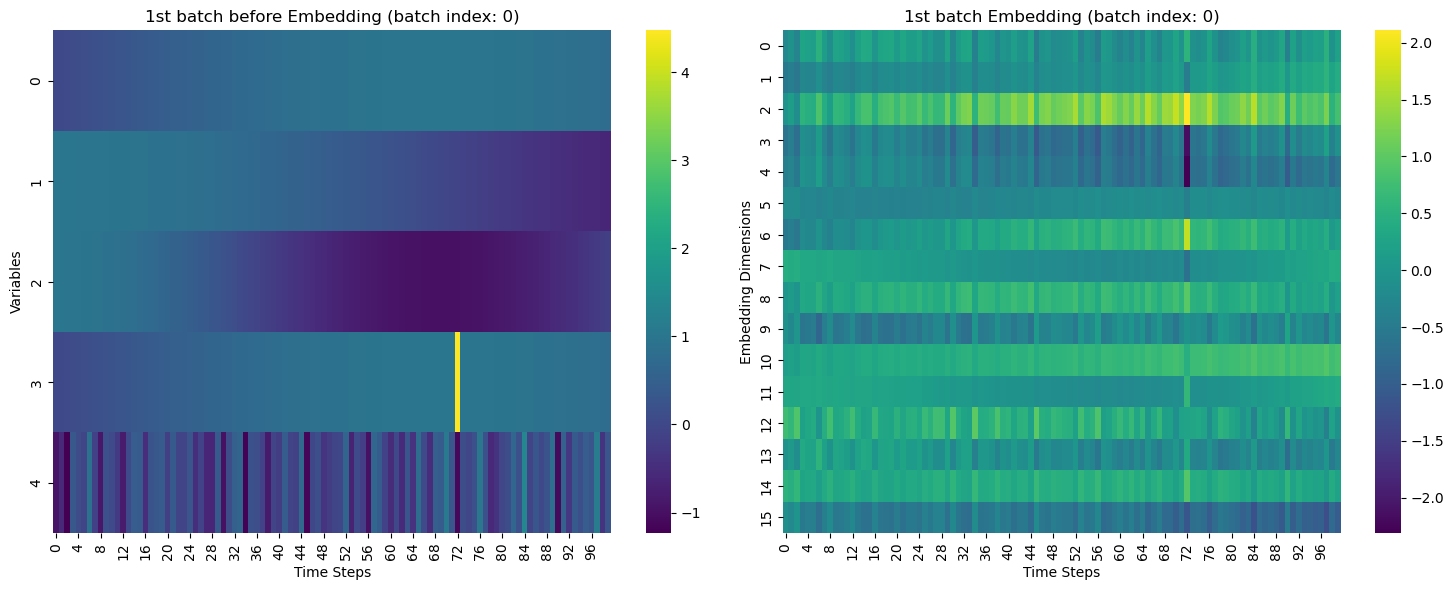


첫 번째 배치 embedding 통계:
평균: 0.0482, 표준편차: 0.4945
최솟값: -2.3095, 최댓값: 2.1082


'\nprint(f"\n100번째 배치 embedding 통계:")\nprint(f"평균: {hundredth_batch.mean():.4f}, 표준편차: {hundredth_batch.std():.4f}")\nprint(f"최솟값: {hundredth_batch.min():.4f}, 최댓값: {hundredth_batch.max():.4f}")\n'

In [32]:
import torch
import torch.nn as nn
import seaborn as sns

class VanillaEmbedding(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()
        self.linear = nn.Linear(input_dim, d_model)

    def forward(self, x):  # x: [B, N, V]
        return self.linear(x)  # [B, N, D]
# 예시 입력
# 데이터 크기: 550, window size: 100
# 슬라이딩 윈도우 방식으로 배치 구성
# 550개 데이터에서 window size 100으로 슬라이딩하면 451개의 샘플 생성 가능
# 각 샘플은 (100, 5) 형태이고, 전체 배치는 (451, 100, 5) 형태

window_size = 100
data_length = X.shape[0]  # 550
num_samples = data_length - window_size + 1  # 451

# 슬라이딩 윈도우로 배치 구성
X_windowed = []
for i in range(num_samples):
    window = X[i:i+window_size]  # (100, 5)
    X_windowed.append(window)

X_tensor = torch.tensor(np.array(X_windowed), dtype=torch.float32)  # shape: (451, 100, 5)
embedding = VanillaEmbedding(input_dim=5, d_model=16)
X_embedded = embedding(X_tensor)  # shape: (451, 100, 16)

print(f"X_tensor shape: {X_tensor.shape}")
print(f"X_embedded shape: {X_embedded.shape}")

# 첫 번째 배치와 100번째 배치의 embedding 값을 heatmap으로 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 첫 번째 배치 - embedding 전 (1, N=100, V=5) (인덱스 0)
first_batch = X_tensor[0].detach().numpy()  # shape: (100, 5)
sns.heatmap(first_batch.T, ax=axes[0], cmap='viridis', cbar=True)
axes[0].set_title('1st batch before Embedding (batch index: 0)')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Variables')

# 첫 번째 배치 (인덱스 0)
first_batch = X_embedded[0].detach().numpy()  # shape: (100, 16)
sns.heatmap(first_batch.T, ax=axes[1], cmap='viridis', cbar=True)
axes[1].set_title('1st batch Embedding (batch index: 0)')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Embedding Dimensions')

'''
# 100번째 배치 (인덱스 99)
hundredth_batch = X_embedded[99].detach().numpy()  # shape: (100, 16)
sns.heatmap(hundredth_batch.T, ax=axes[1], cmap='viridis', cbar=True)
axes[1].set_title('100th batch Embedding (batch index: 99)')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Embedding Dimensions')
'''

plt.tight_layout()
plt.show()

print(f"\n첫 번째 배치 embedding 통계:")
print(f"평균: {first_batch.mean():.4f}, 표준편차: {first_batch.std():.4f}")
print(f"최솟값: {first_batch.min():.4f}, 최댓값: {first_batch.max():.4f}")
'''
print(f"\n100번째 배치 embedding 통계:")
print(f"평균: {hundredth_batch.mean():.4f}, 표준편차: {hundredth_batch.std():.4f}")
print(f"최솟값: {hundredth_batch.min():.4f}, 최댓값: {hundredth_batch.max():.4f}")
'''

In [31]:
first_batch = X_tensor[0].detach().numpy()  # shape: (100, 5)
first_batch.shape

(100, 5)

### VTT의 Dilated Causal ConvEmbedding 방식

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dilated Causal Conv for one variable
class DilatedCausalConvEmbedding(nn.Module):
    def __init__(self, input_channels, d_model, kernel_dilations):
        super().__init__()
        self.dilated_convs = nn.ModuleList([
            nn.Conv1d(input_channels, d_model, kernel_size=k, dilation=d, padding=(k - 1) * d)
            for (k, d) in kernel_dilations
        ])
        self.linear = nn.Linear(d_model * len(kernel_dilations), d_model)

    def forward(self, x):  # x: (B, T, 1) - 배치 크기, 시간 스텝, 단일 변수
        B, T, _ = x.shape  # 입력 텐서의 차원 정보 추출
        
        # Conv1d는 (B, C, L) 형태를 요구하므로 차원 순서 변경
        x = x.permute(0, 2, 1)  # (B, 1, T) - 배치, 채널(1개), 시간 길이
        
        # 각 dilated convolution 연산 수행
        # [:, :, :T]로 슬라이싱하여 원래 시간 길이 T만큼만 유지 (패딩 제거)
        outputs = [conv(x)[:, :, :T] for conv in self.dilated_convs]
        
        # 모든 convolution 출력을 채널 차원에서 연결
        stacked = torch.cat(outputs, dim=1)  # (B, d_model * K, T) - K는 convolution 개수
        
        # linear layer 입력을 위해 차원 순서 재변경
        stacked = stacked.permute(0, 2, 1)   # (B, T, d_model * K) - 시간이 두 번째 차원
        
        # 최종 임베딩 차원으로 변환
        return self.linear(stacked)          # (B, T, D) - 최종 출력 임베딩

# 2. 전체 변수에 대해 적용하는 VTTEmbedding
class VTTEmbedding(nn.Module):
    def __init__(self, num_variables, d_model, kernel_dilations):
        """
        VTTEmbedding 클래스의 초기화 함수
        
        Args:
            num_variables (int): 입력 데이터의 변수 개수 (예: 5개 센서 데이터)
            d_model (int): 임베딩 차원 크기 (예: 16차원)
            kernel_dilations (list): [(커널크기, dilation)] 튜플의 리스트
        """
        super().__init__()
        
        # 각 변수(센서)마다 독립적인 DilatedCausalConvEmbedding 모듈을 생성
        # ModuleList를 사용하여 PyTorch가 이 모듈들을 자동으로 관리하도록 함
        self.embedders = nn.ModuleList([
            DilatedCausalConvEmbedding(
                input_channels=1,           # 각 변수는 단일 채널 입력
                d_model=d_model,           # 출력 임베딩 차원
                kernel_dilations=kernel_dilations  # dilated convolution 설정
            )
            for _ in range(num_variables)  # 변수 개수만큼 임베딩 모듈 생성
        ])

    def forward(self, x):  # x: (B, N, V) - 배치 크기, 시간 스텝, 변수 개수
        """
        VTTEmbedding의 순전파 함수
        
        Args:
            x (torch.Tensor): 입력 텐서 (B, N, V)
                            - B: 배치 크기
                            - N: 시간 스텝 수 (예: 100개 시점)
                            - V: 변수 개수 (예: 5개 센서)
        
        Returns:
            torch.Tensor: 임베딩된 출력 (B, N, V, D)
                         - D: 임베딩 차원 (예: 16차원)
        """
        B, N, V = x.shape  # 입력 텐서의 차원 정보 추출
        outs = []  # 각 변수별 임베딩 결과를 저장할 리스트
        
        # 각 변수(센서)에 대해 독립적으로 임베딩 수행
        for v in range(V):
            # v번째 변수의 데이터만 추출하고 마지막 차원에 채널 차원 추가
            # 채널 차원: 합성곱 신경망(CNN)에서 입력 데이터의 특성 개수를 나타내는 차원
            # 예: RGB 이미지는 3개 채널(빨강, 초록, 파랑), 흑백 이미지는 1개 채널
            # 여기서는 각 변수(센서)가 단일 값이므로 채널=1로 설정
            x_v = x[:, :, v].unsqueeze(-1)      # (B, N, 1) - 단일 변수를 채널로 변환
            # unsqueeze(-1)은 텐서의 마지막 차원에 크기가 1인 새로운 차원을 추가하는 함수
            # 예: (B, N) 형태의 텐서를 (B, N, 1) 형태로 변환
            # 이는 합성곱 연산에 필요한 채널 차원을 만들기 위함
            
            # v번째 변수 전용 임베딩 모듈로 임베딩 수행
            emb_v = self.embedders[v](x_v)      # (B, N, D) - dilated convolution 임베딩
            
            # 변수 차원을 추가하여 나중에 concatenate할 수 있도록 준비
            outs.append(emb_v.unsqueeze(2))     # (B, N, 1, D) - 변수 차원 추가
        
        # 모든 변수의 임베딩을 변수 차원(dim=2)에서 연결
        return torch.cat(outs, dim=2)           # (B, N, V, D) - 최종 출력 형태

# 3. 실제 데이터 X를 사용한 모델 테스트
# X 데이터의 실제 크기 사용: (1000, 100, 5)
B, N, V, D = X_tensor.shape[0], X_tensor.shape[1], X_tensor.shape[2], 16

# 커널 사이즈는 합성곱 연산에서 한 번에 보는 시간 스텝의 개수를 의미
# 예: 커널 사이즈 4 = 연속된 4개 시간 스텝을 한 번에 처리
# dilation은 커널이 적용되는 간격을 조절 (1=연속, 2=한 칸씩 건너뛰며)
kernel_dilations = [(4, 1), (8, 2), (16, 3)]
vtt_model = VTTEmbedding(num_variables=V, d_model=D, kernel_dilations=kernel_dilations)

# 실제 X 데이터를 사용하여 VTT 임베딩 수행
X_vtt_embedded = vtt_model(X_tensor)  # (B, N, V, D) = (1000, 100, 5, 16)

print("X_tensor shape:", X_tensor.shape)           # (1000, 100, 5)
print("X_vtt_embedded shape:", X_vtt_embedded.shape)  # (1000, 100, 5, 16)


X_tensor shape: torch.Size([451, 100, 5])
X_vtt_embedded shape: torch.Size([451, 100, 5, 16])


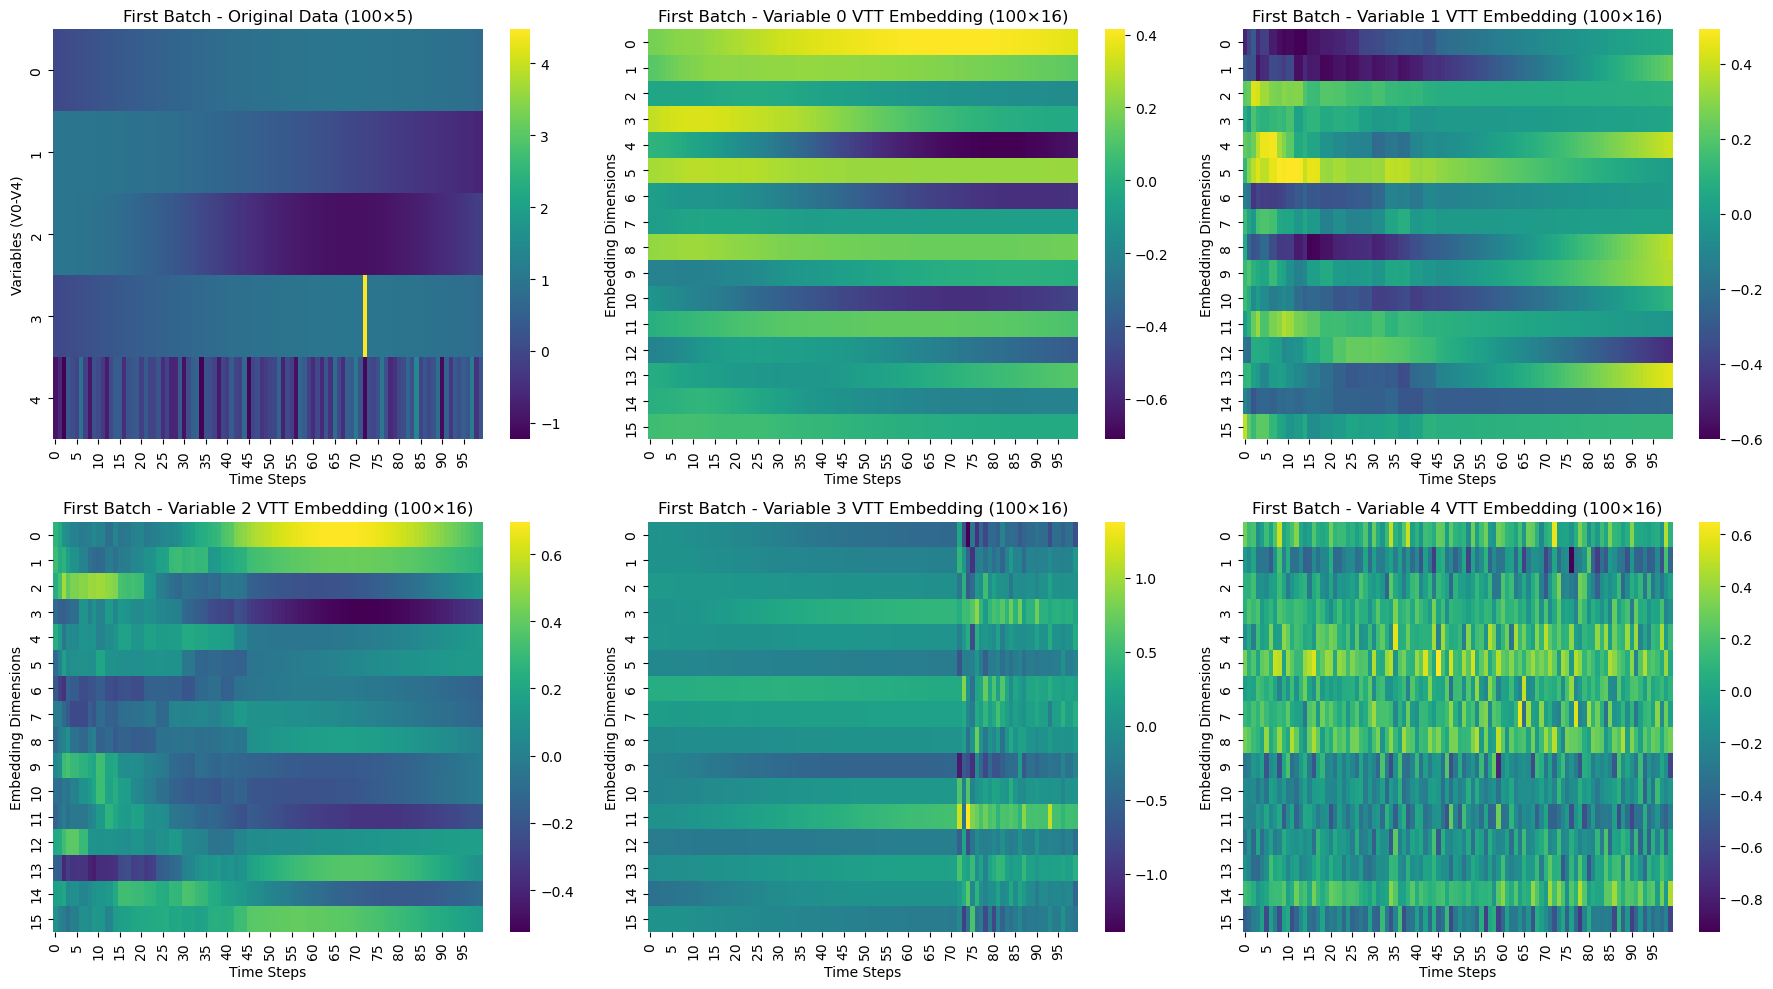


Original Data Statistics:
Mean: 0.3181, Std: 0.6477
Min: -1.2318, Max: 4.4732

VTT Embedding Data Statistics (All Variables):
Mean: -0.0138, Std: 0.2438
Min: -1.3950, Max: 1.3773
Variable 0 - Mean: -0.0344, Std: 0.2538
Variable 1 - Mean: -0.0341, Std: 0.2230
Variable 2 - Mean: 0.0329, Std: 0.2273
Variable 3 - Mean: -0.0103, Std: 0.2720
Variable 4 - Mean: -0.0229, Std: 0.2327


In [36]:

# 4. 첫 번째 배치 시각화
plt.figure(figsize=(18, 10))

# 첫 번째 배치의 원본 데이터 시각화 (1개)
plt.subplot(2, 3, 1)
first_batch_original = X_tensor[0].detach().numpy()  # shape: (100, 5)
sns.heatmap(first_batch_original.T, cmap='viridis', cbar=True)
plt.title('First Batch - Original Data (100×5)')
plt.xlabel('Time Steps')
plt.ylabel('Variables (V0-V4)')

# 첫 번째 배치의 VTT 임베딩 데이터 각 변수별 시각화 (5개)
for v in range(5):
    # subplot(행, 열, 위치) - 2행 3열 격자에서 (v+2)번째 위치에 서브플롯 생성
    # v=0일 때 위치 2, v=1일 때 위치 3, v=2일 때 위치 4, v=3일 때 위치 5, v=4일 때 위치 6
    # 위치 1은 원본 데이터가 차지하므로, 각 변수별 VTT 임베딩은 위치 2~6에 배치
    plt.subplot(2, 3, v + 2)
    # 첫 번째 배치, v번째 변수의 임베딩 데이터 추출
    # detach()는 PyTorch 텐서를 계산 그래프에서 분리하는 메서드
    # gradient가 연결되었다는 것은 해당 텐서가 자동 미분을 위한 계산 그래프의 일부라는 의미
    # 즉, 이 텐서가 어떤 연산들을 통해 생성되었고, 역전파 시 gradient를 계산할 수 있는 상태
    # detach()를 사용하면 이러한 연결을 끊어서 gradient 계산 없이 순수한 데이터만 추출
    # 이는 numpy 배열로 변환하거나 시각화할 때 필요 (gradient 연결된 텐서는 numpy 변환 불가)
    first_batch_vtt_var = X_vtt_embedded[0, :, v, :].detach().numpy()  # shape: (100, 16)
    sns.heatmap(first_batch_vtt_var.T, cmap='viridis', cbar=True)
    plt.title(f'First Batch - Variable {v} VTT Embedding (100×16)')
    plt.xlabel('Time Steps')
    plt.ylabel('Embedding Dimensions')

plt.tight_layout()
plt.show()

# 통계 정보 출력
print(f"\nOriginal Data Statistics:")
print(f"Mean: {first_batch_original.mean():.4f}, Std: {first_batch_original.std():.4f}")
print(f"Min: {first_batch_original.min():.4f}, Max: {first_batch_original.max():.4f}")

print(f"\nVTT Embedding Data Statistics (All Variables):")
first_batch_vtt_all = X_vtt_embedded[0].detach().numpy()  # shape: (100, 5, 16)
print(f"Mean: {first_batch_vtt_all.mean():.4f}, Std: {first_batch_vtt_all.std():.4f}")
print(f"Min: {first_batch_vtt_all.min():.4f}, Max: {first_batch_vtt_all.max():.4f}")

# 각 변수별 통계
for v in range(5):
    var_data = X_vtt_embedded[0, :, v, :].detach().numpy()
    print(f"Variable {v} - Mean: {var_data.mean():.4f}, Std: {var_data.std():.4f}")